In [1]:
import sys
import os 
sys.path.append(os.path.abspath(os.path.join("", "..")))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch import nn
from vanilla_vae import VanillaVAE
import wandb
import gc
import importlib
device = "cuda:0"

In [2]:
import torch
import gc
torch.cuda.empty_cache()
gc.collect()

43

In [3]:
from PIL import Image

## Original image:

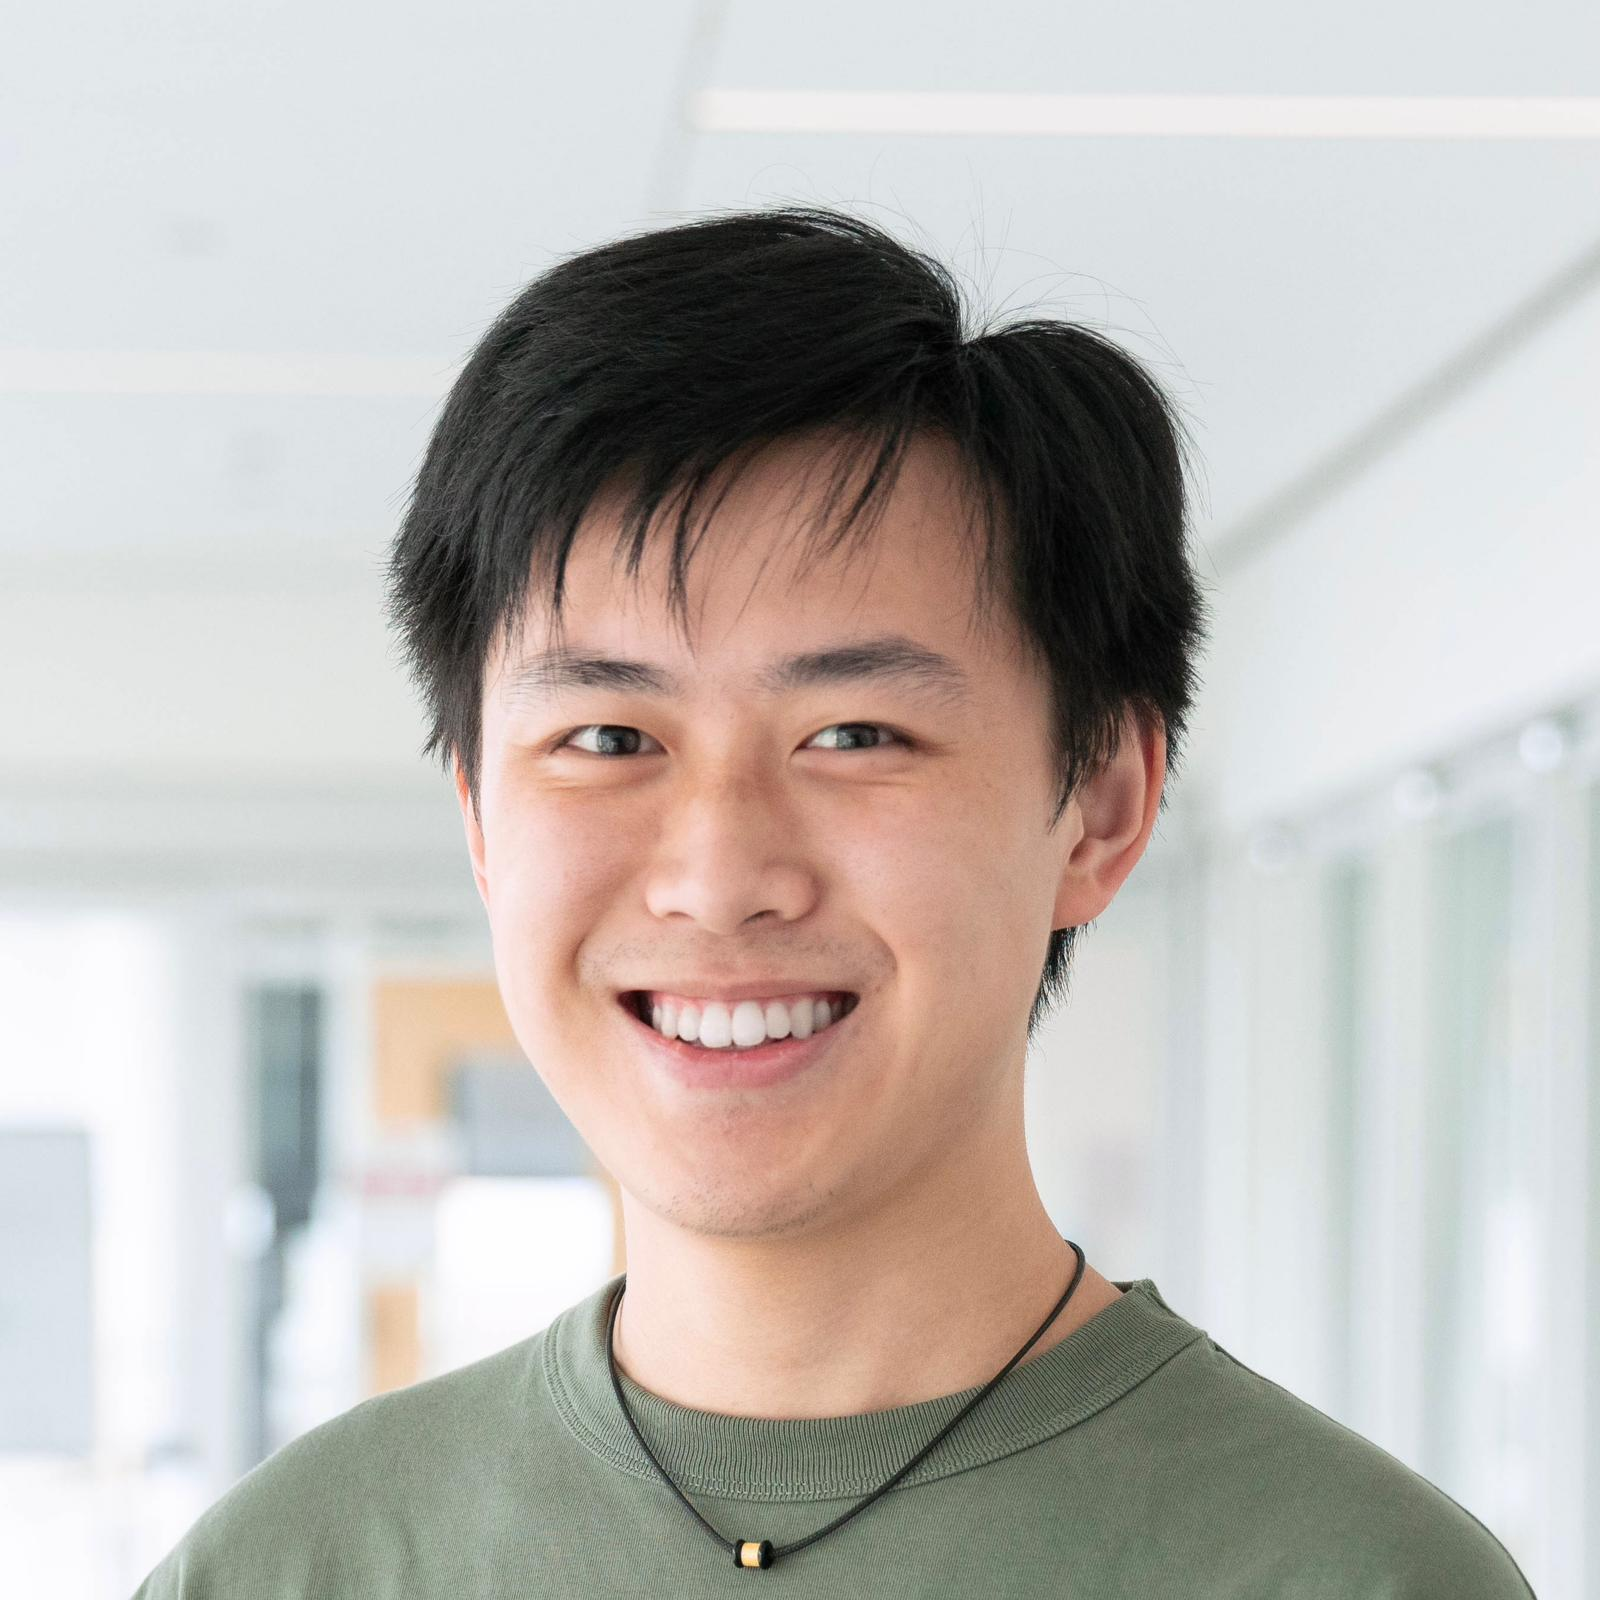

In [4]:
img_path = '../groupfaces/yining/im/person/yining.jpg'
img = Image.open(img_path)
img.show()

## VAE-w2w inversion:

### Step 1: Load VAE-w2w model

In [5]:
# model_save_path = 'temp_vanilla_vae_latent512_beta0.01'

# from vanilla_vae import VanillaVAE

# latent_dim = 512
# beta = 0.01
# hidden_dims=[2048]

# vae_w2w =  VanillaVAE(input_dim=99648, latent_dim=latent_dim, hidden_dims=[2048], beta=beta, batch_norm=False)
# vae_w2w.load_state_dict(torch.load(os.path.join(model_save_path, "model.pt")))
# vae_w2w = vae_w2w.to(device)
# print(f"Model loaded from {model_save_path}")

import vae_w2w.vanilla_vae
importlib.reload(vae_w2w.vanilla_vae)
from vae_w2w.vanilla_vae import VanillaVAE

normalize_by_10 = True
batch_norm = False
latent_dim = 512
yining_hidden_dims = [2048, 1024]
yuchen_hidden_dims = [4096, 2048, 1024]

# yining_vae = VanillaVAE(input_dim=99648, latent_dim=latent_dim,hidden_dims=yining_hidden_dims, batch_norm=False).to(device)
yuchen_vae = VanillaVAE(input_dim=99648, latent_dim=latent_dim,hidden_dims=yuchen_hidden_dims, batch_norm=False).to(device)

yining_model_path = "yining_vae.pt"
yuchen_model_path = "yuchen_vae.pt"

yuchen_state_dict = torch.load(yuchen_model_path, map_location=device)
yuchen_vae.load_state_dict(yuchen_state_dict)

# yining_state_dict = torch.load(yining_model_path, map_location=device)
# yining_vae.load_state_dict(yining_state_dict)

print(f"Model loaded from {yuchen_model_path}")

Model loaded from yuchen_vae.pt


### Step 2: Invert

In [6]:
from utils import load_models
unet, diffusion_vae, text_encoder, tokenizer, noise_scheduler = load_models(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [7]:
import lora_VAEw2w
importlib.reload(lora_VAEw2w)
from lora_VAEw2w import LoRAw2wVAE
torch.cuda.empty_cache()
gc.collect()

50

In [8]:
from inversion_single_image import invert_single_image
from inversion import invert

In [9]:
weight_dimensions_path = "../files/weight_dimensions.pt"
weight_dimensions = torch.load(weight_dimensions_path)

network = LoRAw2wVAE(yuchen_vae, unet).to(device)

total params counted: 99648


In [10]:
print(f"Available GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
print(f"Currently allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
print(f"Max allocated: {torch.cuda.max_memory_allocated() / 1024**3:.2f} GB")

Available GPU memory: 22.18 GB
Currently allocated: 8.28 GB
Max allocated: 8.28 GB


In [11]:
# NEED WARMUP AND SCHEDULER FOR DENOISING LOSS

torch.cuda.empty_cache()
gc.collect()

epochs=400

# lr = 1e-6
lr = 1e-2
weight_decay = 1e-7
num_samples = 7
z_regularizer = True

wandb_proj_name = 'w2w-invert'
wandb_run_name = f'new_inversion-yuchenVAE-e{epochs}-lr{lr}-weight_decay{weight_decay}-s{num_samples}-zreg{z_regularizer}_zeroInstantiate_RAdam+Lookahead'

wandb_name = {'proj': wandb_proj_name, 'run': wandb_run_name}


inverted_network = invert(network=network, unet=unet, vae=diffusion_vae, text_encoder=text_encoder, tokenizer=tokenizer, 
                 prompt = "sks person", noise_scheduler = noise_scheduler, epochs=epochs, 
                 image_path = "../groupfaces/yining/im/", 
                 mask_path = None, device = device, wandb_name=wandb_name, weight_decay=weight_decay, lr=lr, num_samples=num_samples, z_regularizer=z_regularizer)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: fzmautner (fzmautner-carnegie-mellon-university). Use `wandb login --relogin` to force relogin


Optimizer size: 0.00391 MB


100%|██████████| 400/400 [11:13<00:00,  1.68s/it]


### Step 3: Display results

In [12]:
from vae_tester import VAESampleTester

final_latent = network.z
final_latent.shape

torch.Size([512])
L2 norm of z: 0.005750998854637146
torch.Size([1, 99648])


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Sample 0 results:


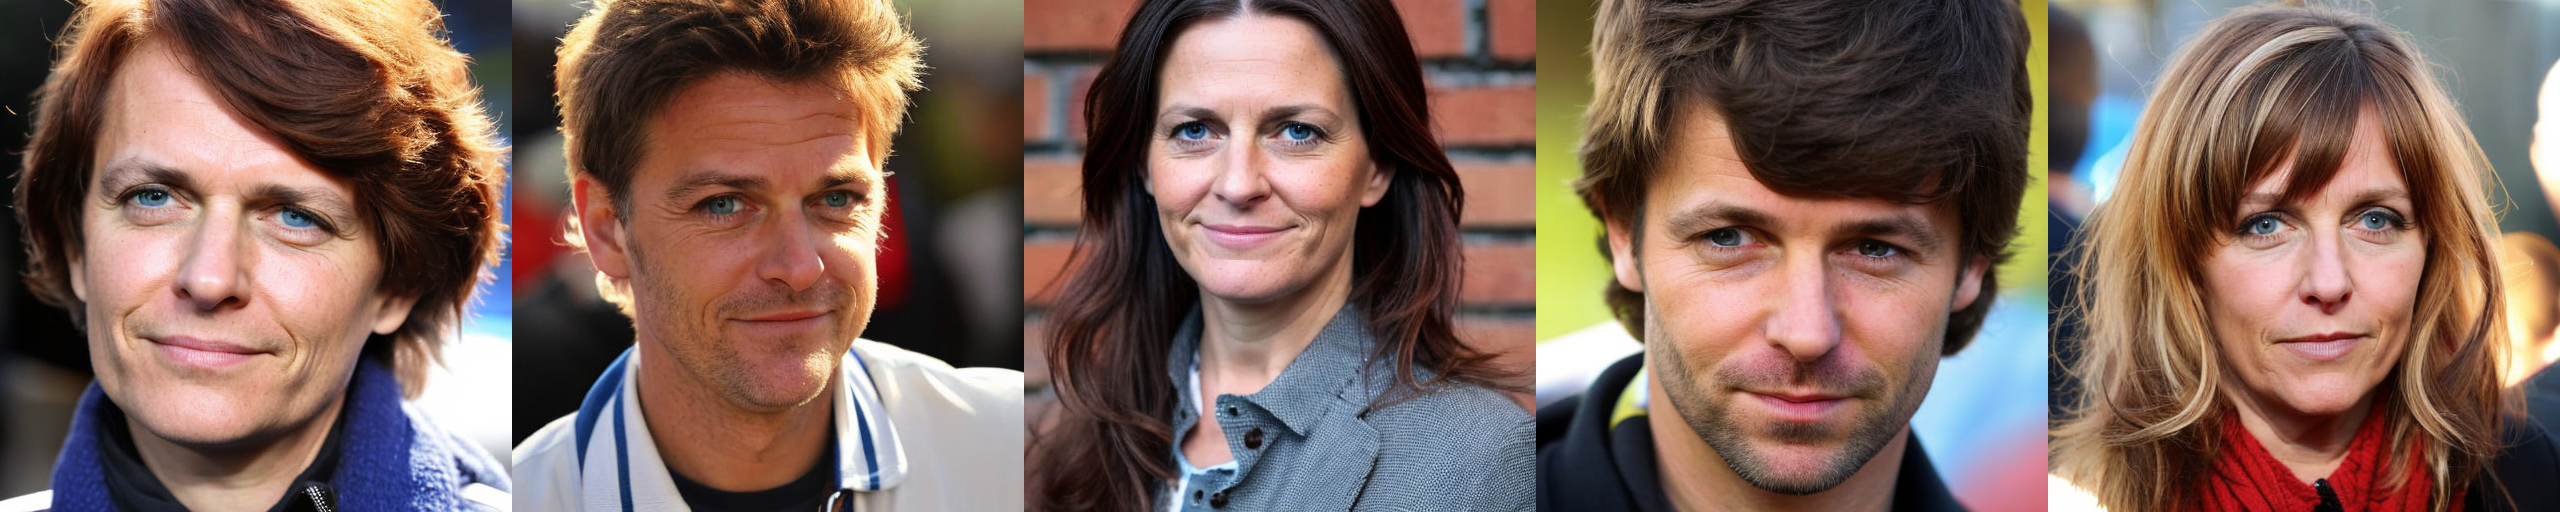

In [13]:
latent_model = network.z
print(latent_model.shape)
print(f"L2 norm of z: {torch.norm(latent_model).item()}")
decoded = network.vae.decode(latent_model.unsqueeze(0)) / 10
print(decoded.shape)
weight_dimensions = torch.load('../files/weight_dimensions.pt')

# Initialize the tester
tester = VAESampleTester(
    vae=vae_w2w,
    weight_dimensions=weight_dimensions,
    device=device
)

# Generate and display images from different samples
def compare_samples(sample_indices, n_images_per_sample=5):
    all_grids = []
    for idx in sample_indices:
        # Generate images
        images = tester.generate_from_sample(
            sample_idx=idx,
            vae_samples=decoded,
            n_images=n_images_per_sample
        )
        
        # Create grid
        grid = tester.create_image_grid(images)
        all_grids.append(grid)

        if wandb.run is not None:
            wandb.log({
                f"sample_{idx}_grid": wandb.Image(grid),
                "sample_index": idx
            })
        
        print(f"Sample {idx} results:")
        display(grid)
        print("\n")

        del images, grid

compare_samples([0])

## Analyzing latent space

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy import stats
import torch

def analyze_vae_latent_space(vae, weights_path, device, n_samples=1000, n_random_samples=1000):
    """
    Comprehensive analysis of VAE latent space characteristics
    
    Args:
        vae: The VAE model
        weights_path: Path to weights dataset
        device: Device to run computations on
        n_samples: Number of samples to take from weights dataset
        n_random_samples: Number of random samples to generate
    """
    plt.style.use('seaborn')
    
    # Load weights dataset and sample random rows
    all_weights = torch.load(weights_path, map_location='cpu')
    indices = torch.randperm(len(all_weights))[:n_samples]
    weight_samples = all_weights[indices]
    
    # Encode samples in batches to save memory
    batch_size = 100
    latent_samples = []
    
    with torch.no_grad():
        for i in range(0, n_samples, batch_size):
            batch = weight_samples[i:i+batch_size].to(device)
            encoded = vae.encode(batch)
            latent_samples.append(encoded.mean.cpu())  # Using mean of encoded distribution
            del batch
            torch.cuda.empty_cache()
    
    latent_samples = torch.cat(latent_samples, dim=0)
    
    # Generate random samples from standard normal for comparison
    random_z = torch.randn(n_random_samples, vae.latent_dim)
    
    # Convert to numpy for analysis
    latent_np = latent_samples.numpy()
    random_z_np = random_z.numpy()
    
    # Create figure for multiple plots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Distribution Analysis
    plt.subplot(3, 2, 1)
    for dim in range(min(5, vae.latent_dim)):
        sns.kdeplot(latent_np[:, dim], label=f'Dim {dim}')
    plt.title('Distribution of Top 5 Latent Dimensions')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    
    # 2. Latent Space Activity
    plt.subplot(3, 2, 2)
    dim_variance = np.var(latent_np, axis=0)
    plt.bar(range(len(dim_variance)), dim_variance)
    plt.axhline(y=0.1, color='r', linestyle='--', label='Activity Threshold')
    active_dims = np.sum(dim_variance > 0.1)
    plt.title(f'Dimension-wise Variance (Active dims: {active_dims}/{vae.latent_dim})')
    plt.xlabel('Latent Dimension')
    plt.ylabel('Variance')
    plt.legend()
    
    # 3. PCA Analysis
    if vae.latent_dim > 2:
        plt.subplot(3, 2, 3)
        pca = PCA(n_components=2)
        latent_pca = pca.fit_transform(latent_np)
        random_pca = pca.transform(random_z_np)
        
        plt.scatter(random_pca[:, 0], random_pca[:, 1], alpha=0.5, label='Random', color='gray')
        plt.scatter(latent_pca[:, 0], latent_pca[:, 1], alpha=0.7, label='Encoded')
        plt.title(f'PCA Projection (Explained var: {pca.explained_variance_ratio_.sum():.2%})')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.legend()
    
    # 4. Correlation Matrix
    plt.subplot(3, 2, 4)
    corr_matrix = np.corrcoef(latent_np.T)
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
    plt.title('Latent Dimension Correlations')
    
    # 5. Reconstruction Quality
    plt.subplot(3, 2, 5)
    recon_error_np = []
    with torch.no_grad():
        for i in range(0, n_samples, batch_size):
            batch = weight_samples[i:i+batch_size].to(device)
            batch_latents = latent_samples[i:i+batch_size].to(device)
            recon = vae.decode(batch_latents)
            error = torch.nn.functional.mse_loss(recon, batch, reduction='none').mean(dim=1)
            recon_error_np.append(error.cpu().numpy())
            del batch, batch_latents, recon
            torch.cuda.empty_cache()
    
    recon_error_np = np.concatenate(recon_error_np)
    sns.histplot(recon_error_np, kde=True)
    plt.title(f'Reconstruction Error (Mean: {recon_error_np.mean():.4f})')
    plt.xlabel('MSE')
    plt.ylabel('Count')
    
    # 6. Statistical Tests
    plt.subplot(3, 2, 6)
    normality_scores = []
    for dim in range(vae.latent_dim):
        _, p_value = stats.normaltest(latent_np[:, dim])
        normality_scores.append(-np.log10(p_value))
    
    plt.bar(range(len(normality_scores)), normality_scores)
    plt.axhline(y=-np.log10(0.05), color='r', linestyle='--', label='p=0.05 threshold')
    plt.title('Normality Test by Dimension')
    plt.xlabel('Latent Dimension')
    plt.ylabel('-log10(p-value)')
    plt.legend()
    
    plt.tight_layout()
    
    # Print summary statistics
    print("\n=== VAE Latent Space Analysis ===")
    print(f"Active dimensions (var > 0.1): {active_dims}/{vae.latent_dim}")
    print(f"Mean latent norm: {np.linalg.norm(latent_np.mean(axis=0)):.4f}")
    print(f"Average reconstruction error: {recon_error_np.mean():.4f}")
    print(f"Dimension correlation (mean abs): {np.abs(corr_matrix - np.eye(corr_matrix.shape[0])).mean():.4f}")
    
    if wandb.run is not None:
        wandb.log({
            "latent_analysis": wandb.Image(plt),
            "active_dimensions": active_dims,
            "mean_reconstruction_error": recon_error_np.mean(),
            "latent_norm": np.linalg.norm(latent_np.mean(axis=0))
        })
    
    return plt.gcf()

# Analyze the latent space
analysis_plot = analyze_vae_latent_space(
    vae=yuchen_vae,
    weights_path='../weights_datasets/identities/all_weights.pt',
    device=device
)
display(analysis_plot)
plt.close()


ModuleNotFoundError: No module named 'sklearn'